# Analysis Challenge Assignment 3

Author: Zecheng Chang  
Course: HUDK 4050

In [1]:
# import packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

%matplotlib inline

#### import data

In [2]:
data = pd.read_csv('aca3_dataset/CollegeScorecard.csv')

/Users/czc/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7,9,1427,1542,1561,1575) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data_dict = pd.read_csv('aca3_dataset/CollegeScorecardDataDictionary-09-12-2015.csv')

Since we are using the data as we used in Analysis Challenge Assignment 1, there are some same process I will omit in this one.

The goal of this project is to identify clusters of similar colleges and universities, I'll choose some variables among the 1725 variables in total. The criteria of choosing the variables is whether the variable a characteristic of the shcool and whether this characteristic will affect students with different backgroud, especially background of family.

Here are the variables I choose:
1. In-state tuition and fees, TUITIONFEE_IN
2. Out-of-state tuition and fees, TUITIONFEE_OUT
3. Median Household income, median_hh_inc
4. Admission Rate, ADM_RATE_ALL
5. Average SAT equivalent score of students admitted, SAT_AVG
6. Percentage first generation students, PAR_ED_PCT_1STGEN

In [4]:
df = data[['TUITIONFEE_IN','TUITIONFEE_OUT','median_hh_inc','ADM_RATE_ALL','SAT_AVG','PAR_ED_PCT_1STGEN']]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7804 entries, 0 to 7803
Data columns (total 6 columns):
TUITIONFEE_IN        4415 non-null float64
TUITIONFEE_OUT       4196 non-null float64
median_hh_inc        0 non-null float64
ADM_RATE_ALL         2484 non-null float64
SAT_AVG              1420 non-null float64
PAR_ED_PCT_1STGEN    7597 non-null object
dtypes: float64(5), object(1)
memory usage: 365.9+ KB


Looks like there are a lot of missing values , expecially for median_hh_inc, alternatives are needed.

I'll be using another three variables that can be used to describe the income of the students' family, they are `DEP_INC_PCT_M1`, `DEP_INC_PCT_M1`, `DEP_INC_PCT_M2`, `DEP_INC_PCT_H1`, `DEP_INC_PCT_H2`

In [6]:
data[['DEP_INC_PCT_M1', 'DEP_INC_PCT_M1', 'DEP_INC_PCT_M2', 'DEP_INC_PCT_H1', 'DEP_INC_PCT_H2']].head(3)

,DEP_INC_PCT_M1,DEP_INC_PCT_M1,DEP_INC_PCT_M2,DEP_INC_PCT_H1,DEP_INC_PCT_H2
0,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,0.030202926
1,0.17260274,0.17260274,0.165601218,0.16042618,0.138508371
2,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed


In [7]:
data[['DEP_INC_PCT_LO', 'DEP_INC_PCT_M1', 'DEP_INC_PCT_M2', 'DEP_INC_PCT_H1', 'DEP_INC_PCT_H2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7804 entries, 0 to 7803
Data columns (total 5 columns):
DEP_INC_PCT_LO    7580 non-null object
DEP_INC_PCT_M1    7580 non-null object
DEP_INC_PCT_M2    7580 non-null object
DEP_INC_PCT_H1    7580 non-null object
DEP_INC_PCT_H2    7580 non-null object
dtypes: object(5)
memory usage: 305.0+ KB


In [8]:
data[['TUITFTE']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7804 entries, 0 to 7803
Data columns (total 1 columns):
TUITFTE    7362 non-null float64
dtypes: float64(1)
memory usage: 61.1 KB


I'll be using `TUITFTE` instead of `TUITIONFEE_IN` and `TUITIONFEE_OUT` since it's a indicator of the intuition as well and it doesn't have many missing values.

I picked `ADM_RATE_ALL` and `SAT_AVG` because I think these 2 variables are good indicators of the quality of the school. Since they have too many missing values as well, alternatives are needed as well.

In [9]:
df = data[['TUITFTE','DEP_INC_PCT_LO', 'DEP_INC_PCT_M1', 'DEP_INC_PCT_M2', 'DEP_INC_PCT_H1', 'DEP_INC_PCT_H2','PAR_ED_PCT_1STGEN']]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7804 entries, 0 to 7803
Data columns (total 7 columns):
TUITFTE              7362 non-null float64
DEP_INC_PCT_LO       7580 non-null object
DEP_INC_PCT_M1       7580 non-null object
DEP_INC_PCT_M2       7580 non-null object
DEP_INC_PCT_H1       7580 non-null object
DEP_INC_PCT_H2       7580 non-null object
PAR_ED_PCT_1STGEN    7597 non-null object
dtypes: float64(1), object(6)
memory usage: 426.9+ KB


For these 3 income variables, I'll combine the 2 with same levels, for example, `DEP_INC_PCT_M1` and `DEP_INC_PCT_M2` are both for students with middle class income family. But first we need to convert them into float.

In [11]:
df.head(3)

,TUITFTE,DEP_INC_PCT_LO,DEP_INC_PCT_M1,DEP_INC_PCT_M2,DEP_INC_PCT_H1,DEP_INC_PCT_H2,PAR_ED_PCT_1STGEN
0,9063.0,0.621047664,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,0.030202926,0.389901823
1,9033.0,0.362861492,0.17260274,0.165601218,0.16042618,0.138508371,0.345362017
2,12057.0,0.594594595,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,0.550314465


In [12]:
df_new = df.loc[(df['DEP_INC_PCT_LO'] != 'PrivacySuppressed') & (df['DEP_INC_PCT_M1'] != 'PrivacySuppressed') &
                (df['DEP_INC_PCT_M2'] != 'PrivacySuppressed') & (df['DEP_INC_PCT_H1'] != 'PrivacySuppressed') &
                (df['DEP_INC_PCT_H2'] != 'PrivacySuppressed') & (df['PAR_ED_PCT_1STGEN'] != 'PrivacySuppressed')]

In [13]:
df_new[['DEP_INC_PCT_LO', 'DEP_INC_PCT_M1', 'DEP_INC_PCT_M2', 'DEP_INC_PCT_H1', 'DEP_INC_PCT_H2','PAR_ED_PCT_1STGEN']] = df_new[['DEP_INC_PCT_LO', 'DEP_INC_PCT_M1', 'DEP_INC_PCT_M2', 'DEP_INC_PCT_H1', 'DEP_INC_PCT_H2','PAR_ED_PCT_1STGEN']].astype(float)

/Users/czc/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [14]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2318 entries, 1 to 7803
Data columns (total 7 columns):
TUITFTE              2076 non-null float64
DEP_INC_PCT_LO       2113 non-null float64
DEP_INC_PCT_M1       2113 non-null float64
DEP_INC_PCT_M2       2113 non-null float64
DEP_INC_PCT_H1       2113 non-null float64
DEP_INC_PCT_H2       2113 non-null float64
PAR_ED_PCT_1STGEN    2114 non-null float64
dtypes: float64(7)
memory usage: 144.9 KB


In [15]:
df_new.dropna(axis=0, inplace=True)

/Users/czc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
df_new.loc[:,'DEP_INC_PCT_MI'] = df_new.loc[:,'DEP_INC_PCT_M1'] + df_new.loc[:,'DEP_INC_PCT_M2']

/Users/czc/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/czc/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [17]:
df_new.loc[:,'DEP_INC_PCT_HI'] = df_new.loc[:,'DEP_INC_PCT_H1'] + df_new.loc[:,'DEP_INC_PCT_H2']

In [18]:
df_new.drop(['DEP_INC_PCT_M1','DEP_INC_PCT_M2','DEP_INC_PCT_H1','DEP_INC_PCT_H2'],axis=1, inplace=True)

/Users/czc/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
df_new.head()

,TUITFTE,DEP_INC_PCT_LO,PAR_ED_PCT_1STGEN,DEP_INC_PCT_MI,DEP_INC_PCT_HI
1,9033.0,0.362861,0.345362,0.338204,0.298935
3,8322.0,0.355848,0.337619,0.299835,0.344316
5,12198.0,0.237031,0.260525,0.282300,0.480669
7,5094.0,0.356481,0.479042,0.372685,0.270833
10,11928.0,0.204878,0.184915,0.300000,0.495122


I plan to build a k means clustering model, TUIFTE is a not in the same scale as other variables.

In [20]:
scaler = MinMaxScaler()

In [21]:
scaler.fit_transform(df_new[['TUITFTE']])

array([[0.05803666],
       [0.05346851],
       [0.07837166],
       ...,
       [0.01876731],
       [0.09688839],
       [0.07579525]])

In [22]:
df_new.loc[:,'TUITFTE_norm'] = scaler.fit_transform(df_new[['TUITFTE']])

/Users/czc/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/czc/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [23]:
df_new['TUITFTE_norm'].describe()

count    1873.000000
mean        0.073086
std         0.049331
min         0.000000
25%         0.039070
50%         0.070469
75%         0.097916
max         1.000000
Name: TUITFTE_norm, dtype: float64

In [24]:
df_new

,TUITFTE,DEP_INC_PCT_LO,PAR_ED_PCT_1STGEN,DEP_INC_PCT_MI,DEP_INC_PCT_HI,TUITFTE_norm
1,9033.0,0.362861,0.345362,0.338204,0.298935,0.058037
3,8322.0,0.355848,0.337619,0.299835,0.344316,0.053469
5,12198.0,0.237031,0.260525,0.282300,0.480669,0.078372
7,5094.0,0.356481,0.479042,0.372685,0.270833,0.032729
10,11928.0,0.204878,0.184915,0.300000,0.495122,0.076637
...,...,...,...,...,...,...
7369,15898.0,0.525548,0.502429,0.310517,0.163934,0.102144
7370,4149.0,0.313681,0.384902,0.370383,0.315935,0.026657
7373,2921.0,0.566412,0.446187,0.295748,0.137840,0.018767
7374,15080.0,0.589605,0.519427,0.287546,0.122848,0.096888


#### Building Model

In [25]:
df_new.to_csv('ICE7_2.csv')

In [114]:
k_range = range(1,10)

sse = []
for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(df_new.drop(['TUITFTE'],axis=1))
    sse.append(km.inertia_)

In [115]:
sse

[99.00698456497817,
 34.674233056198204,
 24.795605163006424,
 18.296190339660974,
 15.501532389456578,
 14.331368251590746,
 13.293594751072304,
 12.389557637388112,
 11.617359352794]

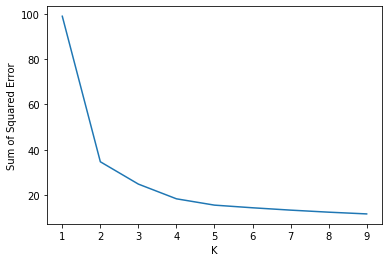

In [117]:
plt.xlabel('K')
plt.ylabel('Sum of Squared Error')
plt.plot(k_range, sse);

I think both 2 and 3 can be the elbow point. Let's validate both of them

In [118]:
km_2 = KMeans(n_clusters=2)
labels_2 = km_2.fit_predict(df_new.drop(['TUITFTE'],axis=1))

km_3 = KMeans(n_clusters=3)
labels_3 = km_3.fit_predict(df_new.drop(['TUITFTE'],axis=1))


df_new['label_2'] = labels_2
df_new['label_3'] = labels_3

/Users/czc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/czc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [124]:
df_new.groupby(['label_3'])[['TUITFTE','DEP_INC_PCT_LO','DEP_INC_PCT_MI','DEP_INC_PCT_HI','PAR_ED_PCT_1STGEN']].mean()

,TUITFTE,DEP_INC_PCT_LO,DEP_INC_PCT_MI,DEP_INC_PCT_HI,PAR_ED_PCT_1STGEN
label_3,,,,,
0,12766.720403,0.248887,0.332350,0.418763,0.342013
1,8713.582150,0.427655,0.346798,0.225546,0.462715
2,12148.290946,0.600246,0.283525,0.116229,0.526118


In [125]:
df_new.groupby(['label_2'])[['TUITFTE','DEP_INC_PCT_LO','DEP_INC_PCT_MI','DEP_INC_PCT_HI','PAR_ED_PCT_1STGEN']].mean()

,TUITFTE,DEP_INC_PCT_LO,DEP_INC_PCT_MI,DEP_INC_PCT_HI,PAR_ED_PCT_1STGEN
label_2,,,,,
0,11267.521293,0.570943,0.296436,0.132621,0.516532
1,11601.218182,0.290460,0.340065,0.369476,0.373734


## Conclusion
We can clearly notice that these 3 clusters of students have very large differences schools characteristics, especially for the 3 clusters model result. The difference in percentage of low income and high income is larger, which means students background vary a lot in these criteara among different shools. 
These results indicate that students who come from a relatively lower income family will get into a school different from students who come from a relatively higher income family, also first generation college students tend to be a school that non_first_generation students won't tend to go to.
